# 1. 필요한 모듈들을 임포트

In [5]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input ,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
from functools import partial

# 2. 데이터 블러오기

In [6]:
caltech_dir = "./HandGesture\images" #학습데이터
categories = ["O", "V", "paper", "rock","side"] #카테고리 나누기
nb_classes = len(categories)#카테고리 길이 결정
image_w = 64
image_h = 64
pixels = image_h * image_w * 3 #픽셀은 64*64에 3층
X = []
y = []
#카테고리 수만큼 전처리 원핫 인코딩
for idx, cat in enumerate(categories): 
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    image_dir = caltech_dir + "/" + cat #cat의 폴더 열기
    files = glob.glob(image_dir+"/*.jpg") #cat에 있는 jpg로 끝나는 파일 읽어오기
    print(cat, " 파일 길이 : ", len(files))#전체 파일 수 i 파일 수 f는 파일 이름
    for i, f in enumerate(files):#파일 수만큼 반복
        img = cv2.imread(f)#이미지 열기 cv2로 열기
        #손 색상 변경
        ycrb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb) #cv2의 색상을 RGB가 아닌 YCrCb로 변경
        img = cv2.inRange(ycrb,np.array([0,133,77]),np.array([255,173,127]))  #해당 색(사람 피부색)에 관련된 색을 구분
        img = Image.fromarray(img) #cv2의 이미지를 PIL형식의 이미지로 변경
        img = img.convert("RGB")#흑백
        img = img.resize((image_w, image_h))#사이즈 변경
        data = np.asarray(img)#np.array로 변경
        X.append(data) #x에 데이터 
        y.append(label) #y에 출력 설정

X = np.array(X) # 데이터 전부 모아서 배열 성정
y = np.array(y)

#학습집합 나누어 주기

#X_train y_train 최종학습 집합
#X_train_f y_train_f 학습 집합
#x_test y_test 테스트 집합
#X_vailed y_vailed 검증 집합
X_train, X_test, y_train, y_test = train_test_split(X, y) 
X_train_f, X_vailed, y_train_f, y_vailed = train_test_split(X_train,y_train)
xy = (X_train, X_test, y_train, y_test,X_train_f, X_vailed, y_train_f, y_vailed)


np.save("./HandGesture/multi_image_data.npy", xy) #넘파이 배열을 저장해 버림
print("ok", len(y))

O  파일 길이 :  805
V  파일 길이 :  624
paper  파일 길이 :  805
rock  파일 길이 :  621
side  파일 길이 :  805
ok 3660


c:\Users\kmc59\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# 3. 이미지 증식

In [7]:
# 데이터 증식 옵션
train_datagen = ImageDataGenerator(rescale = 1/255,rotation_range=30,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.5,zoom_range=0.3,horizontal_flip=True,vertical_flip=True,validation_split=0.2)

In [8]:
# 저장된 데이터 불러오기
#X_train, X_test, y_train, y_test,X_train_f, X_vailed, y_train_f, y_vailed = np.load('./HandGesture/multi_image_data.npy',allow_pickle=True)

# 데이터 증식 적용

#학습집합의 데이터 증식
train_generator = train_datagen.flow(
    x=X_train,y=y_train,
    batch_size = 32,
    shuffle = True
)

#최종 학습 집합 데이터 증식
train_f_generator = train_datagen.flow(
    x=X_train_f,y=y_train_f,
    batch_size = 32,
    shuffle = True
)

#검증 집합 데이터 증식
vailed_generator = train_datagen.flow(
    x=X_vailed,y=y_vailed,
    batch_size = 32,
    shuffle = True
)

#테스트 집합 데이터 증식
test_generator = train_datagen.flow(
    x=X_test,y=y_test,
    batch_size = 32,
    shuffle = True
)

In [9]:
#카테고리 설정
categories = ["O", "V", "paper", "rock","side"] 
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_train_f = X_train_f.astype(float) /255
X_vailed = X_vailed.astype(float) /255

# 4. 예제 코드 신경망

In [10]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same')

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), # 2차원을 1차원으로 변환하여 밀집층으로 연결
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(nb_classes, activation='softmax'),
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

model_dir = './model'

checkpoint_cb = keras.callbacks.ModelCheckpoint("model1.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_1 = model.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,
                   callbacks=[checkpoint_cb, early_stopping_cb])
save_model(model=model,filepath=model_dir+"/model_1")

Epoch 1/10


C:\Users\kmc59\AppData\Local\Temp\ipykernel_8616\674420408.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,


65/65 [==============================] - 24s 346ms/step - loss: 1.6390 - accuracy: 0.3411 - val_loss: 1.2675 - val_accuracy: 0.4323
Epoch 2/10
65/65 [==============================] - 22s 336ms/step - loss: 1.2240 - accuracy: 0.4908 - val_loss: 0.8401 - val_accuracy: 0.6885
Epoch 3/10
65/65 [==============================] - 22s 342ms/step - loss: 0.9946 - accuracy: 0.6088 - val_loss: 0.6346 - val_accuracy: 0.7875
Epoch 4/10
65/65 [==============================] - 22s 341ms/step - loss: 0.8368 - accuracy: 0.6846 - val_loss: 0.4610 - val_accuracy: 0.8341
Epoch 5/10
65/65 [==============================] - 22s 340ms/step - loss: 0.6858 - accuracy: 0.7541 - val_loss: 0.5156 - val_accuracy: 0.8355
Epoch 6/10
65/65 [==============================] - 23s 346ms/step - loss: 0.5895 - accuracy: 0.7949 - val_loss: 0.4152 - val_accuracy: 0.8617
Epoch 7/10
65/65 [==============================] - 23s 347ms/step - loss: 0.5248 - accuracy: 0.8328 - val_loss: 0.3280 - val_accuracy: 0.8937
Epoch 8/10

INFO:tensorflow:Assets written to: ./model/model_1\assets


INFO:tensorflow:Assets written to: ./model/model_1\assets


# 5. 합성곱 + 최대풀링 섞은 신경망

In [11]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same')

model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(nb_classes, activation='softmax'),
])

model2.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

model_dir = './model'

checkpoint_cb = keras.callbacks.ModelCheckpoint("model2.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_2 = model2.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,
                   callbacks=[checkpoint_cb, early_stopping_cb])
save_model(model=model2,filepath=model_dir+"/model_2")

Epoch 1/10


C:\Users\kmc59\AppData\Local\Temp\ipykernel_8616\2082454162.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model2.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,


65/65 [==============================] - 11s 159ms/step - loss: 1.0800 - accuracy: 0.6098 - val_loss: 0.6161 - val_accuracy: 0.7875
Epoch 2/10
65/65 [==============================] - 10s 158ms/step - loss: 0.5767 - accuracy: 0.7901 - val_loss: 0.4510 - val_accuracy: 0.8443
Epoch 3/10
65/65 [==============================] - 11s 162ms/step - loss: 0.4261 - accuracy: 0.8508 - val_loss: 0.9099 - val_accuracy: 0.7351
Epoch 4/10
65/65 [==============================] - 10s 159ms/step - loss: 0.3871 - accuracy: 0.8756 - val_loss: 0.3325 - val_accuracy: 0.8923
Epoch 5/10
65/65 [==============================] - 10s 156ms/step - loss: 0.2721 - accuracy: 0.9140 - val_loss: 0.2153 - val_accuracy: 0.9316
Epoch 6/10
65/65 [==============================] - 10s 157ms/step - loss: 0.2499 - accuracy: 0.9179 - val_loss: 0.2723 - val_accuracy: 0.9141
Epoch 7/10
65/65 [==============================] - 10s 153ms/step - loss: 0.2288 - accuracy: 0.9271 - val_loss: 0.1700 - val_accuracy: 0.9389
Epoch 8/10

INFO:tensorflow:Assets written to: ./model/model_2\assets


INFO:tensorflow:Assets written to: ./model/model_2\assets


# 6. VGG 모델 개선

In [12]:
def model_maker():
    base_model = VGG16(include_top=False, input_shape=(64, 64, 3)) #베이스 모델로는 VGG16 모델을

    for layer in base_model.layers[:-2]:
        layer.trainable = False # Top 층을 제외한 나머지 층에서 2개의 층을 새롭게 학습 
 
    input1 = Input(shape=(64, 64, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(nb_classes, activation='softmax')(custom_model)
    return Model(inputs=input1, outputs=predictions)
model3 = model_maker()

model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

model_dir = './model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = 'model3.h5'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

history_3 = model3.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,
                   callbacks=[checkpoint_cb, early_stopping_cb])

save_model(model=model3,filepath=model_dir+"/model_3")


Epoch 1/10


C:\Users\kmc59\AppData\Local\Temp\ipykernel_8616\3479977727.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_3 = model3.fit_generator(train_f_generator, epochs=10, validation_data=vailed_generator,


65/65 [==============================] - 16s 247ms/step - loss: 0.6573 - acc: 0.7629 - val_loss: 0.2012 - val_acc: 0.9301
Epoch 2/10
65/65 [==============================] - 16s 240ms/step - loss: 0.3160 - acc: 0.8970 - val_loss: 0.1782 - val_acc: 0.9534
Epoch 3/10
65/65 [==============================] - 16s 243ms/step - loss: 0.2377 - acc: 0.9150 - val_loss: 0.0826 - val_acc: 0.9709
Epoch 4/10
65/65 [==============================] - 16s 250ms/step - loss: 0.2194 - acc: 0.9320 - val_loss: 0.0905 - val_acc: 0.9680
Epoch 5/10
65/65 [==============================] - 16s 246ms/step - loss: 0.1492 - acc: 0.9475 - val_loss: 0.0742 - val_acc: 0.9796
Epoch 6/10
65/65 [==============================] - 16s 241ms/step - loss: 0.1639 - acc: 0.9485 - val_loss: 0.0486 - val_acc: 0.9767
Epoch 7/10
65/65 [==============================] - 16s 248ms/step - loss: 0.1125 - acc: 0.9645 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 8/10
65/65 [==============================] - 16s 246ms/step - loss: 0.121

INFO:tensorflow:Assets written to: ./model/model_3\assets


INFO:tensorflow:Assets written to: ./model/model_3\assets


# 7. 최종 모델 학습

In [13]:
#최종모델 불러오기
#model4 = load_model('./model/model_Last')

model4 = model3
history_4 = model4.fit_generator(train_generator,
                        epochs=100,
                        validation_data=test_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])
save_model(model=model4,filepath=model_dir+"/model_Last")


Epoch 1/100


C:\Users\kmc59\AppData\Local\Temp\ipykernel_8616\98138945.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_4 = model4.fit_generator(train_generator,


86/86 [==============================] - 21s 244ms/step - loss: 0.0915 - acc: 0.9698 - val_loss: 0.0699 - val_acc: 0.9770
Epoch 2/100
86/86 [==============================] - 21s 244ms/step - loss: 0.1007 - acc: 0.9676 - val_loss: 0.0326 - val_acc: 0.9891
Epoch 3/100
86/86 [==============================] - 21s 244ms/step - loss: 0.0849 - acc: 0.9716 - val_loss: 0.0604 - val_acc: 0.9803
Epoch 4/100
86/86 [==============================] - 21s 244ms/step - loss: 0.0912 - acc: 0.9709 - val_loss: 0.0540 - val_acc: 0.9749
Epoch 5/100
86/86 [==============================] - 21s 241ms/step - loss: 0.0702 - acc: 0.9752 - val_loss: 0.0401 - val_acc: 0.9836
Epoch 6/100
86/86 [==============================] - 21s 245ms/step - loss: 0.0692 - acc: 0.9785 - val_loss: 0.0319 - val_acc: 0.9880
Epoch 7/100
86/86 [==============================] - 21s 249ms/step - loss: 0.0611 - acc: 0.9811 - val_loss: 0.0275 - val_acc: 0.9880
Epoch 8/100
86/86 [==============================] - 21s 250ms/step - loss

INFO:tensorflow:Assets written to: ./model/model_Last\assets


INFO:tensorflow:Assets written to: ./model/model_Last\assets


## 7.1최종 모델 구조

In [14]:
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                             

## 7.2 최종 모델 성능

In [15]:
print("정확도 : %.4f" % (model3.evaluate(X_test, y_test)[1]))

29/29 [==============================] - 5s 158ms/step - loss: 0.0137 - acc: 0.9923
정확도 : 0.9923


## 7.3 최종 모델 그래프

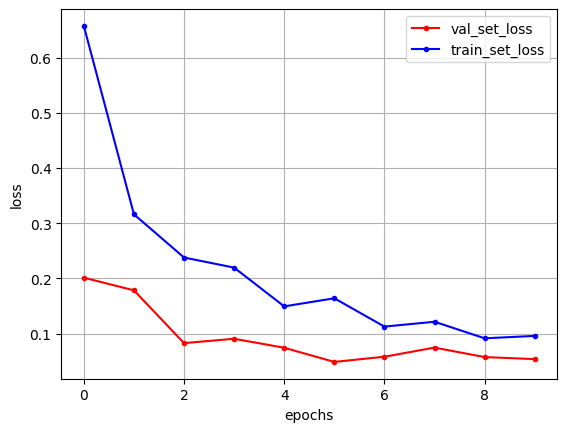

In [16]:
y_vloss = history_3.history['val_loss']
y_loss = history_3.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

# 8. 실행

In [ ]:
from tkinter import * #GUI
import numpy as np 
import cv2 #웹캠
import screen_brightness_control as sbc #화면 밝기 조절
import pyautogui #볼륨 업 다운
import keyboard
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

#  예제 1) tkinter 파이썬 GUI 레이블(label)
# tkinter를 사용하여 텍스트를 나타내보자
# 1. 루트화면 (root window) 생성

def chgkey(x):
    if x == 1: #o
        pyautogui.press('volumeup')
    elif x == 2: #v
        pyautogui.press('volumedown')
    elif x == 3: #r
        pyautogui.press('volumemute')   

def cam():
    cv2.imwrite("self camera test.jpg", frame) # 사진 저장


brightness = sbc.get_brightness()
b = brightness[0]

capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
y=1

while(True):
    ret, frame = capture.read() 
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2YCrCb)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cam()
        
        caltech_dir = "./"
        image_w = 64
        image_h = 64

        pixels = image_h * image_w * 3

        X = []
        filenames = []
        files = glob.glob(caltech_dir+"self camera test.jpg")

        for i, f in enumerate(files):
            img = cv2.imread(f)#이미지 열고
            #손 색상 변경
            ycrb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
            img = cv2.inRange(ycrb,np.array([0,133,77]),np.array([255,173,127])) 
            img = Image.fromarray(img)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            #img.show()
            data = np.asarray(img)
            filenames.append(f)
            X.append(data)

        X = np.array(X)
        model = load_model('./model/model_Last')

        prediction = model.predict(X)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
        cnt = 0
        #이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
        for i in prediction:
            pre_ans = i.argmax()  # 예측 레이블
            print(i)
            print(pre_ans)
            pre_ans_str = ''
            if pre_ans == 0: pre_ans_str = "o"
            elif pre_ans == 1: pre_ans_str = "V"
            elif pre_ans == 2: pre_ans_str = "paper"
            elif pre_ans == 3: pre_ans_str = "rock"
            elif pre_ans == 4: pre_ans_str = "side"
            
            if i[0] >= 0.8 : 
                print("o")
                y=4
            if i[1] >= 0.8: 
                print("v")
                y=5
            if i[2] >= 0.8:
                print("paper") 
                y=1
            if i[3] >= 0.8:
                print("rock") 
                y=2
            if i[4] >= 0.8:
                print("side") 
                y=3
            cnt += 1
            

    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.
    
            #모델로 어떤 기능인지 파악 1, 2, 3, 4 ,5 값을 리턴
        if y == 1:
            chgkey(1)
        elif y == 2:
            chgkey(2)
        elif y == 3:
            chgkey(3)
        elif y == 4:
            brightness[0] -= 10
            if brightness[0] < 0 :
                brightness[0] = 0
            sbc.set_brightness(brightness[0])
        elif y == 5:
            brightness[0] += 10
            if brightness[0] > 100:
                brightness[0] = 100
            sbc.set_brightness(brightness[0])
        else : 
            print("인식되지 않음")
        
        
capture.release()
cv2.destroyAllWindows()   




# 번외 사진으로 테스트 작업

In [17]:
"""caltech_dir = "./HandGesture/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")

for i, f in enumerate(files):
    img = cv2.imread(f)#이미지 열고
    #손 색상 변경
    ycrb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    img = cv2.inRange(ycrb,np.array([0,133,77]),np.array([255,173,127])) 
    img = Image.fromarray(img)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    #img.show()
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model_Last')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "o"
    elif pre_ans == 1: pre_ans_str = "V"
    elif pre_ans == 2: pre_ans_str = "paper"
    elif pre_ans == 3: pre_ans_str = "rock"
    else: pre_ans_str = "side"
   
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.
"""

'caltech_dir = "./HandGesture/test"\nimage_w = 64\nimage_h = 64\n\npixels = image_h * image_w * 3\n\nX = []\nfilenames = []\nfiles = glob.glob(caltech_dir+"/*.*")\n\nfor i, f in enumerate(files):\n    img = cv2.imread(f)#이미지 열고\n    #손 색상 변경\n    ycrb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)\n    img = cv2.inRange(ycrb,np.array([0,133,77]),np.array([255,173,127])) \n    img = Image.fromarray(img)\n    img = img.convert("RGB")\n    img = img.resize((image_w, image_h))\n    #img.show()\n    data = np.asarray(img)\n    filenames.append(f)\n    X.append(data)\n\nX = np.array(X)\nmodel = load_model(\'./model_Last\')\n\nprediction = model.predict(X)\nnp.set_printoptions(formatter={\'float\': lambda x: "{0:0.3f}".format(x)})\ncnt = 0\n\n#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.\nfor i in prediction:\n    pre_ans = i.argmax()  # 예측 레이블\n    print(i)\n    print(pre_ans)\n    pre_ans_str = \'\'\n    if pre_ans == 0: pre_ans_str = "o"\n    elif pre_ans == 1: pre_ans_str = "V"\n   